# Epsilon Greedy Contextual Bandit Agent

## Description:
The epsilon greedy algorithm is a popular exploration-exploitation strategy used in reinforcement learning. It is commonly used in the context of multi-armed bandit problems, where an agent needs to decide which action to take in order to maximize its cumulative reward.

## Principle:
The principle of the epsilon greedy algorithm is to balance exploration and exploitation. The agent chooses between two options: exploration, where it selects a random action to gather more information about the environment, and exploitation, where it selects the action with the highest estimated reward based on its current knowledge.


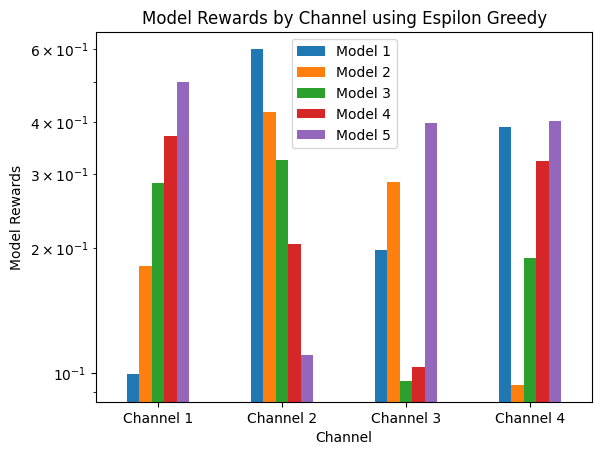

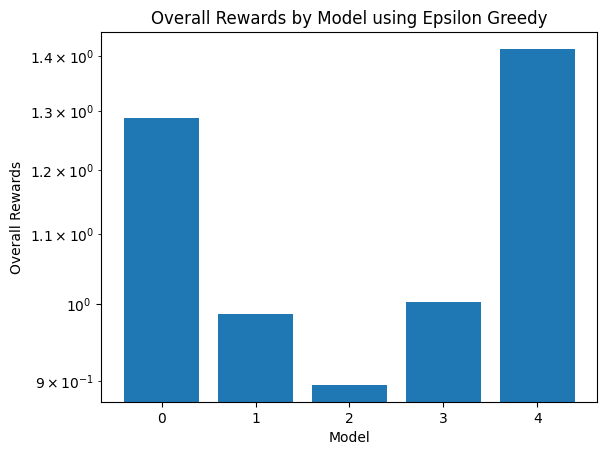

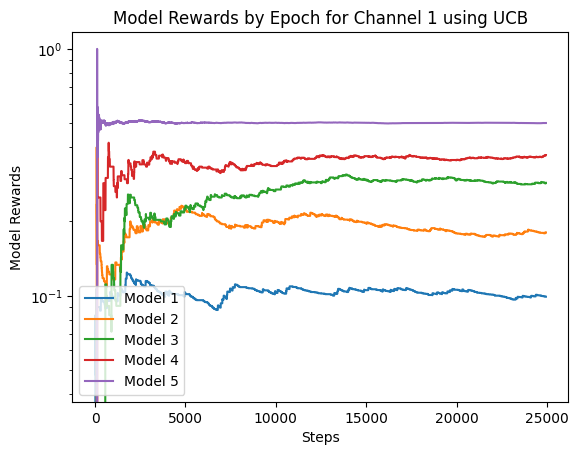

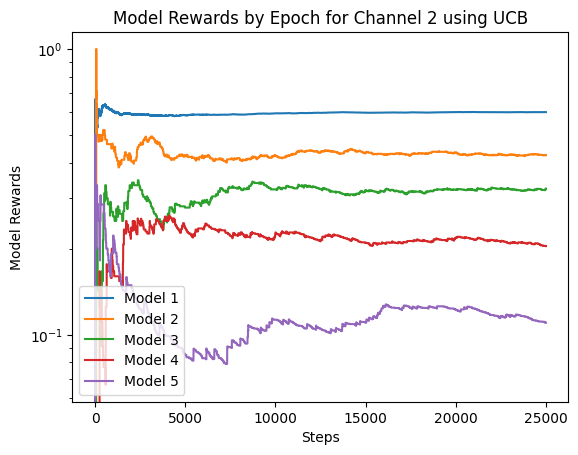

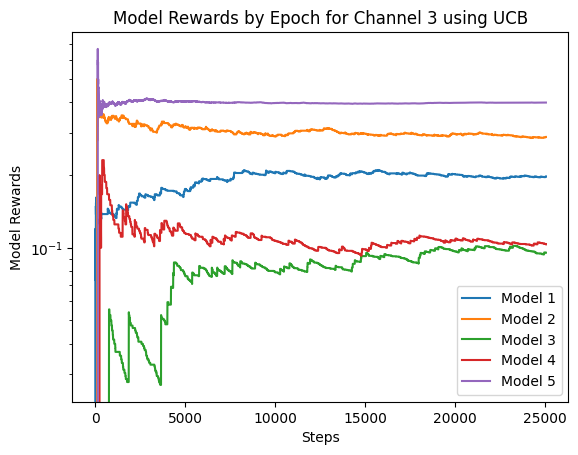

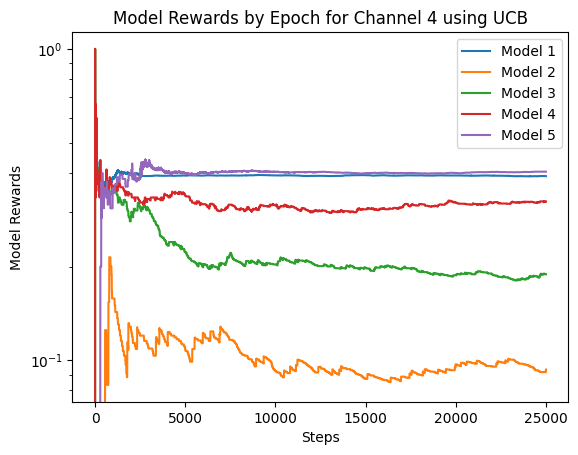

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class ContextualBandit:
    def __init__(self, num_channels: int, num_models: int, reward_probabilities: np.ndarray) -> None:
        """
        Initializes a ContextualBandit object.

        Args:
            num_channels (int): The number of channels.
            num_models (int): The number of models.
            reward_probabilities (np.ndarray): The reward probabilities for each channel and model.
        """
        self.num_channels = num_channels
        self.num_models = num_models
        self.reward_probabilities = reward_probabilities
    
    def get_reward(self, channel: int, model: int) -> int:
        """
        Gets the reward for a given channel and model.

        Args:
            channel (int): The channel index.
            model (int): The model index.

        Returns:
            int: The reward (0 or 1).
        """
        reward_probability = self.reward_probabilities[channel][model]
        return np.random.choice([0, 1], p=[1 - reward_probability, reward_probability])


class EpsilonGreedyAgent:
    def __init__(self, num_channels: int, num_models: int, epsilon: float, num_epochs) -> None:
        """
        Initializes an EpsilonGreedyAgent object.

        Args:
            num_channels (int): The number of channels.
            num_models (int): The number of models.
            epsilon (float): The exploration rate.
        """
        self.num_channels = num_channels
        self.num_models = num_models
        self.epsilon = epsilon
        self.model_rewards_per_channel = np.zeros((num_channels, num_models))
        self.action_counts = np.zeros((num_channels, num_models))
        self.total_rewards_per_model = np.zeros(num_models)
        # Add model rewards per channel per epoch 
        self.model_rewards_per_channel_per_epoch = np.zeros((num_epochs, num_channels, num_models))
        self.channel_played_per_epoch = np.zeros((num_epochs, num_channels))
    
    def update_reward_estimate(self, channel: int, model: int, reward: int, epoch: int) -> None:
        """
        Updates the reward estimate for a given channel and model.

        Args:
            channel (int): The channel index.
            model (int): The model index.
            reward (int): The received reward.
            epoch (int): The epoch index.
        """
        self.action_counts[channel][model] += 1
        alpha = 1 / self.action_counts[channel][model]
        reward_calculated = alpha * (reward - self.model_rewards_per_channel[channel][model])
        self.model_rewards_per_channel[channel][model] += reward_calculated
        self.total_rewards_per_model[model] += reward_calculated
         # Update the rewards per model per channel per epoch by adding the reward for the selected model to previous step's reward.
        self.model_rewards_per_channel_per_epoch[epoch, channel, model] = self.model_rewards_per_channel[channel, model]
        # Update other non-selected models rewards per channel per epoch by setting the previous model_rewards_per_channel value of those model to be the current value.
        self.model_rewards_per_channel_per_epoch[epoch, channel, np.arange(self.num_models) != model] = self.model_rewards_per_channel[channel, np.arange(self.num_models) != model]
        self.channel_played_per_epoch[epoch, channel] = 1
        
    
    def choose_action(self, channel: int) -> int:
        """
        Chooses an action for a given channel based on the reward estimates.

        Args:
            channel (int): The channel index.

        Returns:
            int: The selected action.
        """
        if np.random.rand() < self.epsilon:
            # Explore: select a random action
            action = np.random.randint(self.num_models)
        else:
            # Exploit: select the action with the highest estimated reward
            action = np.argmax(self.model_rewards_per_channel[channel])
        return action
    
    def train(self, bandit: ContextualBandit, num_episodes: int) -> None:
        """
        Trains the agent on the given bandit environment.

        Args:
            bandit (ContextualBandit): The contextual bandit environment.
            num_episodes (int): The number of episodes to train for.
        """
        for episode in range(num_episodes):
            channel = np.random.randint(bandit.num_channels)
            action = self.choose_action(channel)
            reward = bandit.get_reward(channel, action)
            self.update_reward_estimate(channel, action, reward, episode)

if __name__ == "__main__":
    # Define the bandit environment and train the agent
    num_channels = 4
    num_models = 5
    num_epochs = 100000
    reward_probabilities = np.array([[0.1, 0.2, 0.3, 0.4, 0.5],
                                    [0.6, 0.4, 0.3, 0.2, 0.1],
                                    [0.2, 0.3, 0.1, 0.1, 0.4],
                                    [0.4, 0.1, 0.2, 0.3, 0.4]])
    bandit = ContextualBandit(num_channels, num_models, reward_probabilities)
    agent = EpsilonGreedyAgent(num_channels, num_models, epsilon=0.1, num_epochs=num_epochs)
    agent.train(bandit, num_episodes=num_epochs)
    
    # create a dataframe with model rewards and group by channel
    df = pd.DataFrame(agent.model_rewards_per_channel, columns=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
    df['Channel'] = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']
    df = df.set_index('Channel')

    df.plot(kind='bar', rot=0)
    plt.xlabel('Channel')
    plt.ylabel('Model Rewards')
    plt.title('Model Rewards by Channel using Espilon Greedy')
    plt.yscale('log')

    # create a bar chart of the overall rewards for each model
    plt.figure()
    plt.bar(range(agent.num_models), agent.total_rewards_per_model)
    plt.xlabel('Model')
    plt.ylabel('Overall Rewards')
    plt.title('Overall Rewards by Model using Epsilon Greedy')
    plt.yscale('log')
    plt.show()
    

    # create line charts of the model reward per channel per played epoch
    for channel in range(agent.num_channels):
        played_epochs = np.where(agent.channel_played_per_epoch[:, channel] == 1)[0]
        plt.figure()
        for model in range(agent.num_models):
            plt.plot(np.arange(len(played_epochs)), agent.model_rewards_per_channel_per_epoch[played_epochs, channel, model], label=f'Model {model+1}')
        plt.xlabel('Steps')
        plt.ylabel('Model Rewards')
        plt.title(f'Model Rewards by Epoch for Channel {channel+1} using UCB')
        plt.yscale('log')
        plt.legend()
        plt.show()
